In [1]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

import geopandas as gpd
from shapely.geometry import Point

from platform import python_version

print(python_version())

3.11.6


In [2]:
# Initialize S3 client with anonymous access
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

# List objects in the S3 bucket (No credentials required)
bucket_name = "dataforgood-fb-data"
prefix = "forests/v1/alsgedi_global_v6_float/"  # Folder in S3

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Print first 10 file names
for obj in response.get("Contents", [])[:10]:
    print(obj["Key"])

forests/v1/alsgedi_global_v6_float/
forests/v1/alsgedi_global_v6_float/CHM_acquisition_date.tif
forests/v1/alsgedi_global_v6_float/chm/
forests/v1/alsgedi_global_v6_float/chm/001311332.tif
forests/v1/alsgedi_global_v6_float/chm/001311333.tif
forests/v1/alsgedi_global_v6_float/chm/001313101.tif
forests/v1/alsgedi_global_v6_float/chm/001313103.tif
forests/v1/alsgedi_global_v6_float/chm/001313110.tif
forests/v1/alsgedi_global_v6_float/chm/001313111.tif
forests/v1/alsgedi_global_v6_float/chm/001313112.tif


In [3]:
# Initialize anonymous S3 client
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

# Define bucket and file key
bucket_name = "dataforgood-fb-data"
file_key = "forests/v1/alsgedi_global_v6_float/tiles.geojson"
local_filename = "tiles.geojson"

# Download the GeoJSON file
s3.download_file(bucket_name, file_key, local_filename)

print(f"Downloaded {file_key} as {local_filename}")

Downloaded forests/v1/alsgedi_global_v6_float/tiles.geojson as tiles.geojson


        tile                                           geometry
0  023013213  POLYGON ((-115.31250 33.13755, -115.31250 33.7...
1  021210020  POLYGON ((-123.04688 54.57206, -123.04688 54.9...
2  130122211  POLYGON ((115.31250 56.94497, 115.31250 57.326...
3  121022223  POLYGON ((46.40625 55.77657, 46.40625 56.17002...
4  310111000  POLYGON ((130.07812 -0.70311, 130.07812 0.0000...


<Axes: >

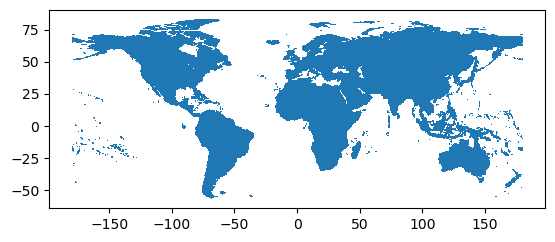

In [4]:
# Load GeoJSON into a GeoDataFrame
tiles_gdf = gpd.read_file("tiles.geojson")

# Show first few rows
print(tiles_gdf.head())

# Plot the tiles (optional)
tiles_gdf.plot()

R code:
```
# 2. DEFINE BUFFER
#-----------------

# 59.911491, 10.757933

lat <- 59.911491
long <- 10.757933

city_coords <- sf::st_point(
    c(long, lat)
) |>
sf::st_sfc(crs = 4326) |>
sf::st_buffer(
    dist = units::set_units(
        2, km
    )
)
```


In [5]:
# City point: 59.911491, 10.757933
# Define latitude and longitude for the city (Oslo, Norway)
lat, lon = 59.89, 10.55

# Create a point geometry
city_point = Point(lon, lat)

# Convert to a GeoDataFrame with CRS 4326 (WGS 84)
gdf = gpd.GeoDataFrame(geometry=[city_point], crs="EPSG:4326")

# Reproject to a meters-based CRS (EPSG:3857) for accurate distance calculations
gdf = gdf.to_crs("EPSG:3857")

# Create a single buffer polygon of 2 km around the point
buffer_polygon = gdf.unary_union.buffer(2000)

# Convert the buffer into a GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_polygon], crs="EPSG:3857")

# Reproject back to latitude/longitude (EPSG:4326)
buffer_gdf = buffer_gdf.to_crs("EPSG:4326")

# Display the buffer GeoDataFrame
print(buffer_gdf)

# Optional: Plot the buffer
#buffer_gdf.plot(figsize=(6, 6), edgecolor="black", alpha=0.5)

                                            geometry
0  POLYGON ((10.56797 59.89000, 10.56788 59.88912...


In [6]:
# Ensure both GeoDataFrames have the same CRS
tiles_gdf = tiles_gdf.to_crs(buffer_gdf.crs)

# Find intersecting tiles
intersecting_tiles = tiles_gdf[tiles_gdf.intersects(buffer_gdf.unary_union)]

# Display results
print(intersecting_tiles)

            tile                                           geometry
9462   120021312  POLYGON ((10.54688 59.53432, 10.54688 59.88894...
18262  120021313  POLYGON ((11.25000 59.53432, 11.25000 59.88894...
34615  120021310  POLYGON ((10.54688 59.88894, 10.54688 60.23981...
37195  120021311  POLYGON ((11.25000 59.88894, 11.25000 60.23981...


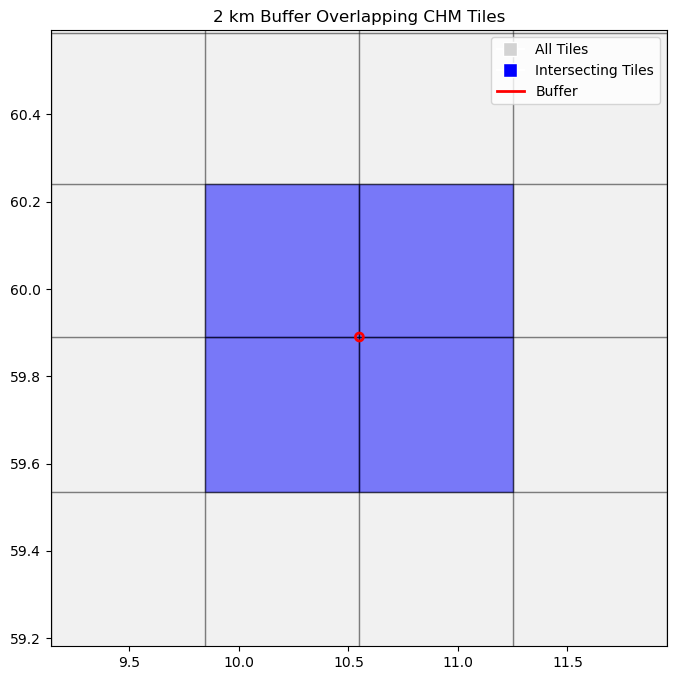

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all tiles (light grey)
tiles_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.3)

# Plot intersecting tiles (blue)
intersecting_tiles.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)

# Plot buffer (red outline)
buffer_gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

# Manually create legend handles
legend_handles = [
    Line2D([0], [0], marker="s", color="w", markerfacecolor="lightgrey", markersize=10, label="All Tiles"),
    Line2D([0], [0], marker="s", color="w", markerfacecolor="blue", markersize=10, label="Intersecting Tiles"),
    Line2D([0], [0], color="red", linewidth=2, label="Buffer"),
]

# Add custom legend
plt.legend(handles=legend_handles, loc="upper right")

# **Adjust plot extent** (Zoom to 2× width of selected tiles)
if not intersecting_tiles.empty:
    minx, miny, maxx, maxy = intersecting_tiles.total_bounds
    width = maxx - minx
    height = maxy - miny
    buffer_factor = 2  # Expand the view by 2×

    ax.set_xlim(minx - width / buffer_factor, maxx + width / buffer_factor)
    ax.set_ylim(miny - height / buffer_factor, maxy + height / buffer_factor)

# Add title and show plot
plt.title("2 km Buffer Overlapping CHM Tiles")
plt.show()


We can assume that when working at city level four tiles is the maximum, but this could be extended to any intersection under the buffer. For this demonstrator we are going to: 
- download all files that intersect
- clip each tile to the extent of the buffer
- combine all the parts.

It's possible to combine all tiles first, and then do the clipping, but as these tiles are large combining them will be a memory strain.

In [8]:
# Assuming intersecting_tiles has a column 'tiles' that contains the tile filenames
# Example: intersecting_tiles["tiles"] = ["001311332.tif", "001311333.tif", ...]
#
# 120021312 is a tile under the buffer
# 
# Define the bucket and prefix for the folder
#bucket_name = "dataforgood-fb-data"
prefix = "forests/v1/alsgedi_global_v6_float/chm/"

# Loop through the tile filenames and check if the file is available
data_available_boo = True
for tile in intersecting_tiles["tile"]:
    file_name = f"{prefix}{tile}.tif"  # Construct full file path
    file_size = None  # You can set the file size here if needed, or use AWS metadata

    try:
        # Check if the file exists by trying to head the object
        # Get the metadata for the file to check availability and size
        response = s3.head_object(Bucket=bucket_name, Key=file_name)

        # Extract file size from the response
        file_size = response["ContentLength"] / 1_000_000  # Convert to MB

        print(f"File {file_name} (Size: {file_size}) is available.")
    except s3.exceptions.ClientError as e:
        # If a client error occurs (e.g., file not found)
        print(f"File {file_name} is NOT available. Error: {e}")
        data_available_boo = False

File forests/v1/alsgedi_global_v6_float/chm/120021312.tif (Size: 743.738209) is available.
File forests/v1/alsgedi_global_v6_float/chm/120021313.tif (Size: 639.724301) is available.
File forests/v1/alsgedi_global_v6_float/chm/120021310.tif (Size: 778.555071) is available.
File forests/v1/alsgedi_global_v6_float/chm/120021311.tif (Size: 681.241115) is available.


The print should give an indication of the size when the file is available or returns an error, the test data_available is used for the next step, if one out of any is not available the code stops.

Also, as expected the files are heavy, so we are first going to clip when the data is available

R- Code
the main difference here is the use of ```chmloader``` this is a package especially writen for R, the next cells are doing the same but then for Python, in several steps, resulting in the same city image.
```
# 3. GET TREE HEIGHT DATA
#------------------------

city_chm <- chmloader::download_chm(
    city_coords,
    filename = "oslo-chm.tif"
)

city_chm_new <- terra::ifel(
    city_chm == 0,
    NA,
    city_chm
)

terra::plot(
    city_chm_new,
    col = hcl.colors(
        64, "viridis"
    )
)
```

In [9]:
def print_raster_info(src, verbose=True):
    """Function to print raster metadata and details for inspection."""
    if verbose:
        print("Metadata of the raster:")
        print(src.meta)  # Metadata of the raster file

        print("\nRaster CRS (Coordinate Reference System):")
        print(src.crs)  # CRS used by the raster

        print("\nRaster Bounds (minx, miny, maxx, maxy):")
        print(src.bounds)  # Bounds of the raster file

        print("\nRaster Dimensions (Width, Height):")
        print(src.width, src.height)  # Dimensions of the raster (width x height)

        print("\nRaster Transform (affine transform for georeferencing):")
        print(src.transform)  # Transform object for geo-referencing

        print("\nRaster Count (number of bands):")
        print(src.count)  # Number of bands in the raster

Metadata of the raster:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 65536, 'height': 65536, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.1943285669558819, 0.0, 1095801.2374962866,
       0.0, -1.1943285669558605, 8375052.315150191)}

Raster CRS (Coordinate Reference System):
EPSG:3857

Raster Bounds (minx, miny, maxx, maxy):
BoundingBox(left=1095801.2374962866, bottom=8296780.798186172, right=1174072.7544603073, top=8375052.315150191)

Raster Dimensions (Width, Height):
65536 65536

Raster Transform (affine transform for georeferencing):
| 1.19, 0.00, 1095801.24|
| 0.00,-1.19, 8375052.32|
| 0.00, 0.00, 1.00|

Raster Count (number of bands):
1


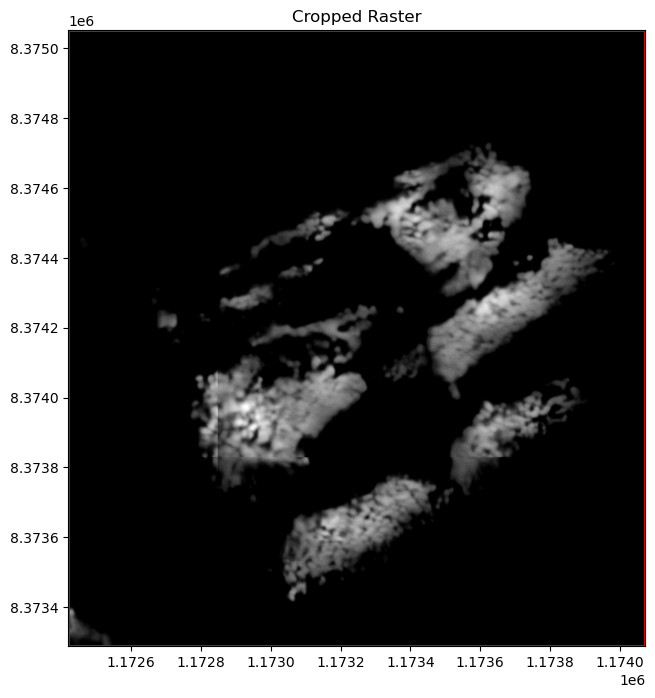


Shape of the output image after clipping:
(1, 1478, 1384)
checkpoint


In [10]:
import rasterio
from rasterio.plot import show  # Correct import


import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import Polygon

import boto3
import s3fs

import os


data_available_boo 


# Get the extent of the buffer feature in the GeoDataFrame (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = buffer_gdf.geometry.total_bounds

# Create a Polygon from the extent
extent_polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

# Reproject the extent_polygon to match the raster's CRS
# Convert extent_polygon to a GeoDataFrame and reproject it
extent_gdf = gpd.GeoDataFrame(geometry=[extent_polygon], crs="EPSG:4326")  # Assuming extent is in EPSG:4326


#  Define S3 bucket and file name
bucket_name = "dataforgood-fb-data"
file_name = "forests/v1/alsgedi_global_v6_float/chm/120021312.tif"

# Define S3 path
s3_url = f"s3://{bucket_name}/{file_name}"

# Create an S3 file system instance with no-sign-request (for public files)
fs = s3fs.S3FileSystem(anon=True)  # anon=True disables signing for public data

# Open the GeoTIFF file directly from S3 using rasterio and s3fs
with rasterio.open(fs.open(s3_url)) as src:
    # Call the function to print metadata, if desired
    print_raster_info(src, verbose=True)  # Set to False to turn off printing

    # Get the bounds of the raster to define the extent (BoundingBox)
    minx, miny, maxx, maxy = src.bounds

    # Define the extent as a Polygon (same CRS as raster)
    extent_polygon_image = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

    # Reproject the extent_polygon to match the raster's CRS
    extent_gdf = extent_gdf.to_crs(src.crs)  # Reproject to match the raster's CRS
    extent_polygon_buffer = extent_gdf.geometry.iloc[0]  # Extract the reprojected polygon

    # Visualize the extent polygon to ensure it's correctly aligned
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("Extent Polygon over Raster")

    # Clip the extent_polygon to the raster bounds (intersection of both bounding boxes)
    clipped_extent = extent_polygon_buffer.intersection(Polygon([
         (minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)
     ]))

    # Visualize the clipped extent
    gpd.GeoDataFrame(geometry=[clipped_extent], crs=src.crs).plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    # Get the window (bounding box) of the raster within the clipped extent
    minx_clip, miny_clip, maxx_clip, maxy_clip = clipped_extent.bounds
    window = rasterio.windows.from_bounds(minx_clip, miny_clip, maxx_clip, maxy_clip, transform=src.transform)

    # Read the data for the cropped area
    cropped_data = src.read(1, window=window)  # Read the first band in the cropped window

    # Plot the cropped raster using imshow
    ax.imshow(cropped_data, cmap='gray', extent=[minx_clip, maxx_clip, miny_clip, maxy_clip])
    ax.set_title("Cropped Raster")
    plt.show()

    # Clip the raster using the reprojected extent polygon (bounding box)
    out_image, out_transform = mask(src, [clipped_extent], crop=True)

    # Check the shape of the output image after clipping
    print("\nShape of the output image after clipping:")
    print(out_image.shape)  # This will tell you if the image size is reasonable

    # Save the clipped raster locally
    # with rasterio.open(output_file, "w", **out_meta) as dst:
    #     dst.write(out_image)
    # print(f"File has been clipped and saved as {output_file}")
    
    # Optionally upload the clipped file to another S3 bucket
    #s3.upload_file(output_file, "your-bucket", "subsets/120021312_extent_clipped_from_polygon.tif")
    #print(f"File has been clipped and uploaded to S3 as {output_file}")
print("checkpoint")

In [11]:
extent_polygon_image.bounds

(1095801.2374962866, 8296780.798186172, 1174072.7544603073, 8375052.315150191)

In [12]:
extent_polygon_buffer.bounds

(1172420.6278690363, 8373288.2155809775, 1176420.627869036, 8377288.2155809775)

In [13]:
import rasterio
from rasterio.io import MemoryFile
import s3fs
from rasterio.mask import mask
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.merge import merge

def process_raster(tile, buffer_polygon):
    """
    Clip the raster using the buffer polygon and return the clipped image data.
    """
    # Create an S3 file system instance with no-sign-request (for public files)
    fs = s3fs.S3FileSystem(anon=True)  # anon=True disables signing for public data

    # Define S3 bucket and file name for each tile
    file_name = tile['tile']  # Assuming the tiles column holds the file name
    file_name = f"{file_name }.tif"  # Construct full file path
    print(file_name)
    
    s3_url = f"s3://dataforgood-fb-data/forests/v1/alsgedi_global_v6_float/chm/{file_name}"

    with rasterio.open(fs.open(s3_url)) as src:
        # Get the bounds of the raster to define the extent (BoundingBox)
        minx, miny, maxx, maxy = src.bounds
    
        # Define the extent as a Polygon (same CRS as raster)
        extent_polygon_image = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])

        # Reproject the extent_polygon to match the raster's CRS
        extent_gdf = buffer_polygon.to_crs(src.crs)  # Reproject to match the raster's CRS
        extent_polygon_buffer = extent_gdf.geometry.iloc[0]  # Extract the reprojected polygon

        extent_polygon_buffer = extent_gdf.geometry.iloc[0]  # Extract the reprojected polygon
    
        # Clip the extent_polygon to the raster bounds (intersection of both bounding boxes)
        clipped_extent = extent_polygon_buffer.intersection(extent_polygon_image)
        print(clipped_extent)

        # Get the window (bounding box) of the raster within the clipped extent
        minx_clip, miny_clip, maxx_clip, maxy_clip = clipped_extent.bounds
        window = rasterio.windows.from_bounds(minx_clip, miny_clip, maxx_clip, maxy_clip, transform=src.transform)

        # Read the data for the cropped area
        cropped_data = src.read(1, window=window)  # Read the first band in the cropped window

        # Store the relevant metadata
        metadata = src.profile
        metadata.update({
            'driver': 'GTiff',
            'count': 1,  # Single band
            'dtype': 'float32',
            'width': cropped_data.shape[1],
            'height': cropped_data.shape[0],
            'transform': src.window_transform(window),
        })

        # Create a temporary file path for saving the clipped raster
        temp_raster_path = os.path.join(f"clipped_{file_name}.tif")

        # Save the clipped raster to the temporary directory
        with rasterio.open(temp_raster_path, "w", **metadata) as dst:
            dst.write(cropped_data, 1)

        # Return the path of the saved clipped raster
        return temp_raster_path

clipped_images_metadata = []

# Loop through each tile and save the clip to the drive
for index, row in intersecting_tiles.iterrows():
    # Clip the tile and append the result (metadata) to the list
    temp_raster_path = process_raster(row,  extent_gdf)
    clipped_images_metadata.append(temp_raster_path)

print("end loop")


120021312.tif
POLYGON ((1172420.6278690363 8375052.315150191, 1174072.7544603073 8375052.315150191, 1174072.7544603073 8373288.2155809775, 1172420.6278690363 8373288.2155809775, 1172420.6278690363 8375052.315150191))
120021313.tif
POLYGON ((1176420.627869036 8373288.2155809775, 1174072.7544603073 8373288.2155809775, 1174072.7544603073 8375052.315150191, 1176420.627869036 8375052.315150191, 1176420.627869036 8373288.2155809775))
120021310.tif
POLYGON ((1172420.6278690363 8377288.2155809775, 1174072.7544603073 8377288.2155809775, 1174072.7544603073 8375052.315150191, 1172420.6278690363 8375052.315150191, 1172420.6278690363 8377288.2155809775))
120021311.tif
POLYGON ((1176420.627869036 8377288.2155809775, 1176420.627869036 8375052.315150191, 1174072.7544603073 8375052.315150191, 1174072.7544603073 8377288.2155809775, 1176420.627869036 8377288.2155809775))
end loop


In [14]:
import rasterio
from rasterio.merge import merge
import os

# After processing all tiles, create the mosaic
if clipped_images_metadata:
    # Read the clipped rasters into rasterio dataset objects
    datasets = []
    for raster_path in clipped_images_metadata:
        datasets.append(rasterio.open(raster_path))  # Open each raster

    # Use rasterio.merge.merge to mosaic the images
    mosaic_image, mosaic_transform = merge(datasets)

    # Set up the metadata for the output file (using the profile of the first tile)
    out_meta = datasets[0].profile
    out_meta.update({
        "driver": "GTiff",
        "count": 1,  # Single band output
        "transform": mosaic_transform,
        "width": mosaic_image.shape[2],  # Width is the 3rd dimension of the 3D array (bands, height, width)
        "height": mosaic_image.shape[1],  # Height is the 2nd dimension
    })

    # Save the mosaic to a file
    output_file = "mosaic_raster.tif"
    with rasterio.open(output_file, "w", **out_meta) as dst:
        dst.write(mosaic_image[0], 1)  # Since it's single-band, we need to write only the first band

    print(f"Mosaic raster saved as {output_file}")

    # Close all datasets manually to ensure they're not locked
    for dataset in datasets:
        dataset.close()  # Explicitly close each dataset

    # Optionally, clean up the temporary files (make sure the datasets are closed before deleting)
    for raster_path in clipped_images_metadata:
        os.remove(raster_path)
    print(f"Temporary files cleaned up.")
else:
    print("No clipped images to mosaic.")

Mosaic raster saved as mosaic_raster.tif
Temporary files cleaned up.


File handling is necessary as working with memory objects/files is not easy when a loop is involved (losing the context by the context manager), so a temporary save of the intermediate images is a quick workaround (this could be optimised).

The last step in this block is the plotting of the data:

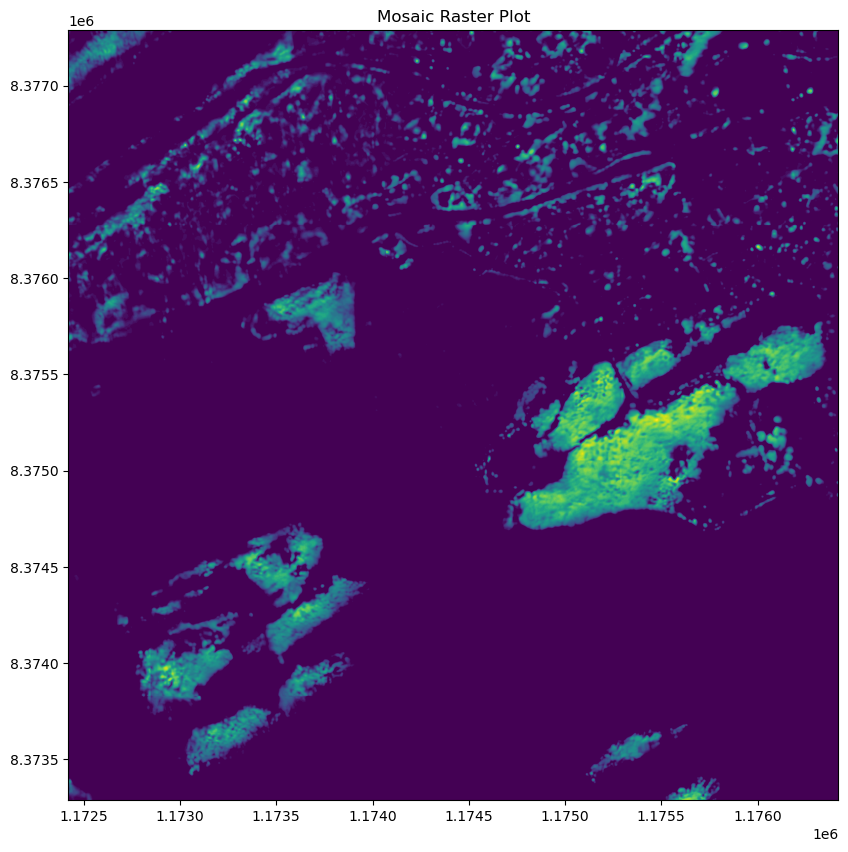

In [15]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Open the saved mosaic raster file
mosaic_file = "mosaic_raster.tif"

with rasterio.open(mosaic_file) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot using rasterio's show function with the 'viridis' colormap
    show(src, ax=ax, cmap="viridis")
    
    ax.set_title("Mosaic Raster Plot")
    plt.show()


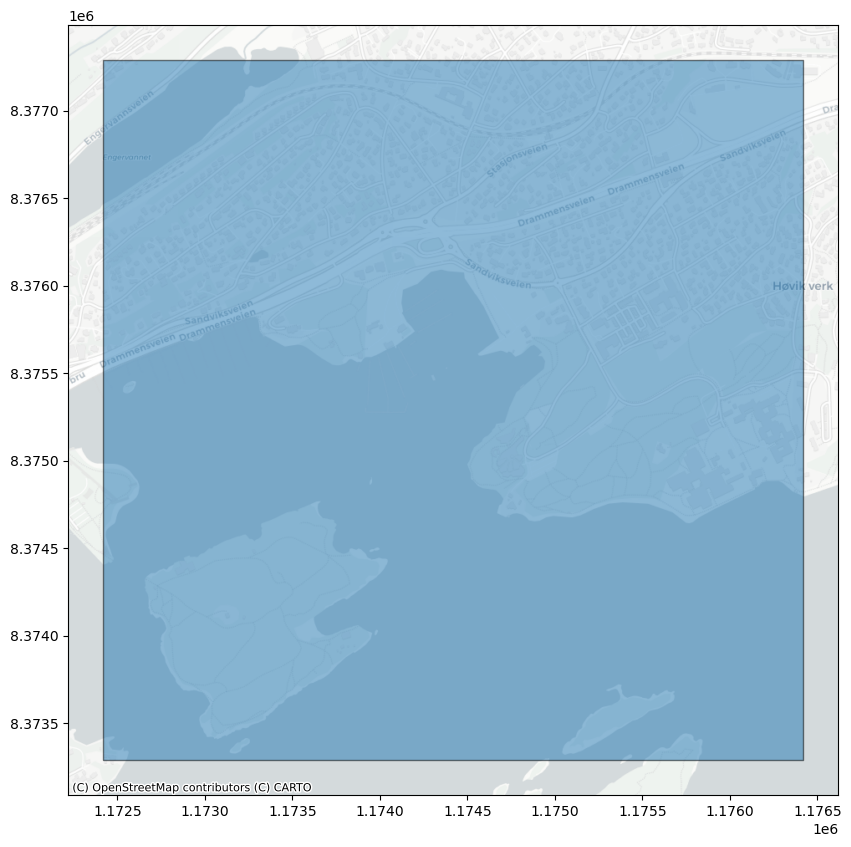

In [16]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

# Ensure extent_gdf has a valid CRS
if extent_gdf.crs is None:
    extent_gdf.set_crs(epsg=4326, inplace=True)  # Assuming it's in WGS84

# Convert to Web Mercator (EPSG:3857) for contextily basemap
city_wm = extent_gdf.to_crs(epsg=3857)

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))
city_wm.plot(ax=ax, alpha=0.5, edgecolor="k")

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)  # Explicitly set the basemap provider

plt.show()


It is at this point where the R-code and Python code start to differ.

To sumarise: 
Step 5: Raster to DataFrame (Alternative Approach in R)
In R, raster data is often converted into a dataframe for easier manipulation in ggplot2. Each pixel’s coordinates (x, y) and corresponding value (chm) are stored in a structured format.

In Python, we typically keep raster data as a NumPy array and extract relevant statistics directly, avoiding conversion to a dataframe unless needed for a specific plotting library.

Step 6: Defining Breaks and Color Palette
R uses classInt::classIntervals() to create evenly spaced breaks for classifying canopy height values into discrete groups. These breaks are then mapped to a color scale using hcl.colors().

In Python, we can achieve a similar effect with numpy.histogram_bin_edges() (for breaks) and matplotlib.colors for colormaps.

Step 7: Visualization with ggplot2
The R code uses ggplot2 and tidyterra to overlay:

- A basemap (geom_spatraster_rgb).
- A raster heatmap (geom_raster) with a gradient fill based on canopy height.
- A colorbar legend (scale_fill_gradientn) for interpreting values.
  
In Python, we can achieve the same effect using Matplotlib + Rasterio + Contextily, with imshow() for raster display and add_basemap() for the background.

In [17]:
# Step 5:
import rasterio
import numpy as np

# Open the raster file
raster_path = mosaic_file 
with rasterio.open(raster_path) as src:
    # Read the data from the raster file as a NumPy array
    raster_data = src.read(1)  # Read the first band (assuming single-band raster)
    profile = src.profile
    bounds = src.bounds

    # Get the NoData value from the raster
    nodata_value = src.nodata

# Now, raster_data is a NumPy array of pixel values
print(raster_data.shape)  # Print the shape of the raster data array


(3349, 3349)


This is interesting, we got a ~3.3km data block over a 2000m radius, and you would expect that the data block would be 4000x4000, but the 500 pixel difference can originate from the projection and the distance away from the equator

The image be;ow shows the distribution of heights in the data:

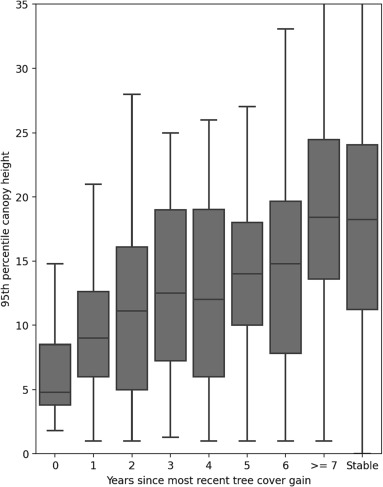

source: https://www.sciencedirect.com/science/article/pii/S003442572300439X

Tolan, J., Yang, H. I., Nosarzewski, B., Couairon, G., Vo, H. v., Brandt, J., Spore, J., Majumdar, S., Haziza, D., Vamaraju, J., Moutakanni, T., Bojanowski, P., Johns, T., White, B., Tiecke, T., & Couprie, C. (2024). Very high resolution canopy height maps from RGB imagery using self-supervised vision transformer and convolutional decoder trained on aerial lidar. Remote Sensing of Environment, 300. https://doi.org/10.1016/j.rse.2023.113888

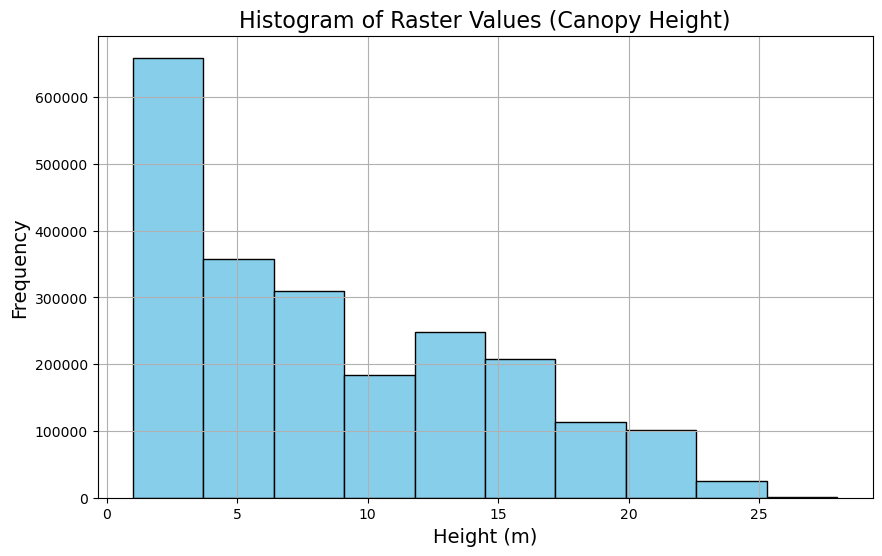

In [18]:
# Remove the NoData values from the data for the histogram
if nodata_value is not None:
    raster_data = raster_data[raster_data != nodata_value]
    
# Replace zero with NoData value
# If NoData is not defined, use np.nan as the NoData value
if nodata_value is None:
    nodata_value = np.nan

# Replace zero with NoData value
raster_data[raster_data == 0] = nodata_value


# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(raster_data.flatten(), color='skyblue', edgecolor='black')
plt.title('Histogram of Raster Values (Canopy Height)', fontsize=16)
plt.xlabel('Height (m)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

In [19]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr


# Prettier plotting with seaborn
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")


[-inf, 2, 5, 10, 15, 20, 25, inf]


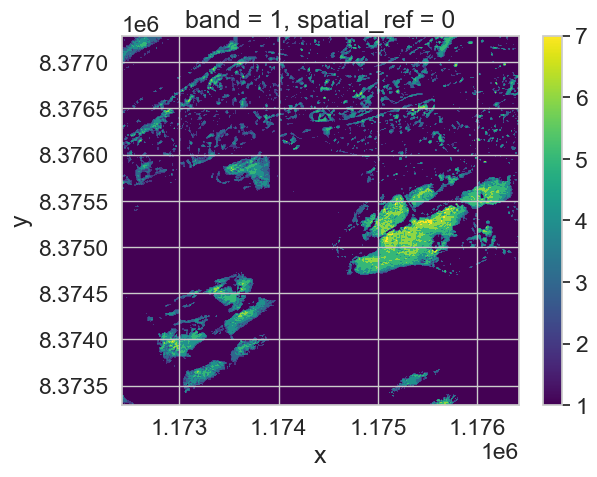

In [20]:
# Open Tree height file
raster_data = rxr.open_rasterio(mosaic_file, masked=True).squeeze()

class_bins = [-np.inf, 2, 5, 10, 15, 20, 25, np.inf]
print(class_bins)

raster_data_class = xr.apply_ufunc(np.digitize,
                                     raster_data,
                                     class_bins)

# Values of 5 represent missing data
im = raster_data_class.plot.imshow()
ax.set_axis_off()

# Mask out values not equalt to 1 or  6 (the outside classes, np.inf)
raster_data_ma = raster_data_class.where(raster_data_class != 7)
raster_data_ma = raster_data_ma.where(raster_data_ma != 1)



In [21]:
raster_data_ma 

<xarray.DataArray (y: 3349, x: 3349)>
array([[ 3.,  3.,  2., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       [ 3.,  3.,  3., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int32 1
  * x            (x) float64 1.172e+06 1.172e+06 ... 1.176e+06 1.176e+06
  * y            (y) float64 8.377e+06 8.377e+06 ... 8.373e+06 8.373e+06
    spatial_ref  int32 0

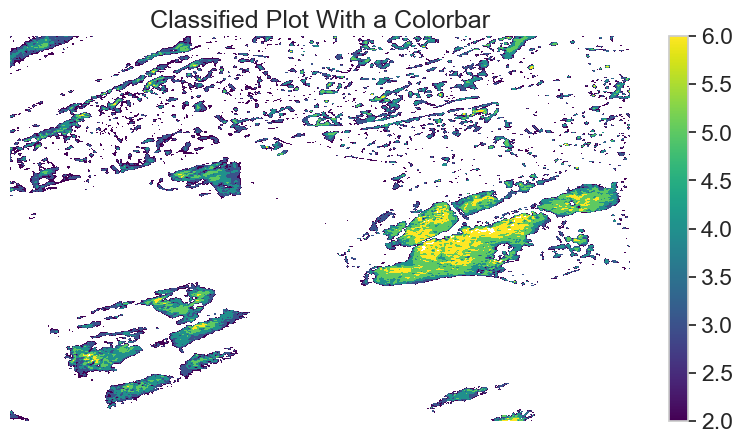

In [22]:
# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10,5))
raster_data_ma .plot.imshow()
ax.set(title="Classified Plot With a Colorbar")

ax.set_axis_off()
plt.show()

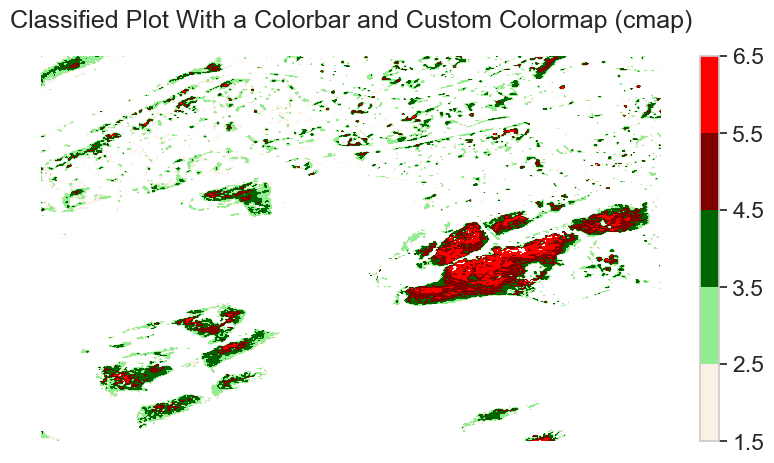

In [23]:
# Plot data using nicer colors
colors = ['linen', 'lightgreen', 'darkgreen', 'maroon', 'red']
class_bins = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5 ]
cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 5))
raster_data_ma.plot.imshow(cmap=cmap,
                                   norm=norm)
ax.set(title="Classified Plot With a Colorbar and Custom Colormap (cmap)")
ax.set_axis_off()
plt.show()

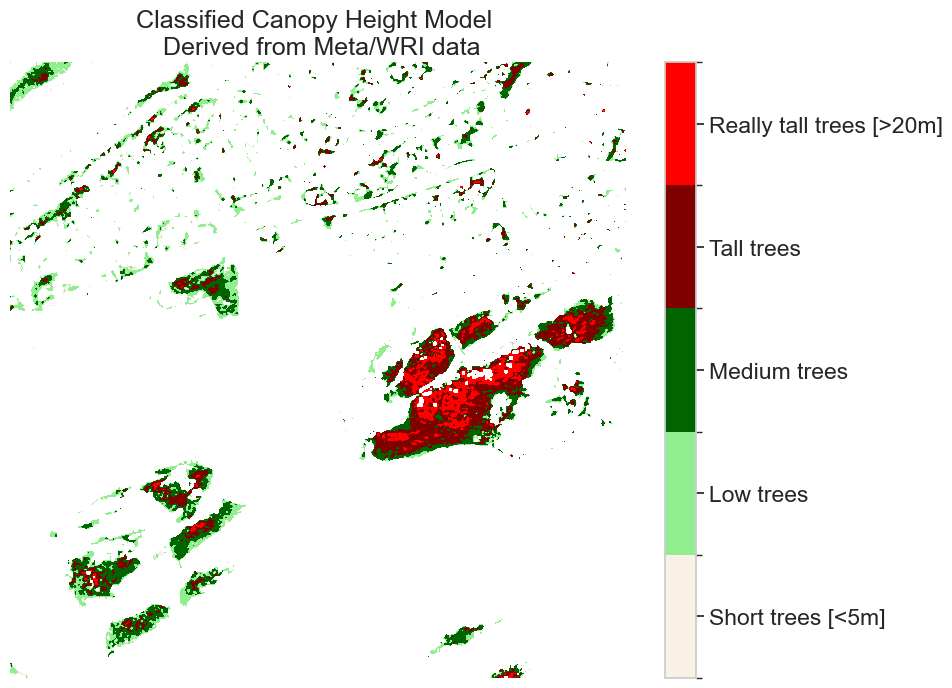

In [25]:
# Assuming raster_data_ma is already loaded and masked

# Create a list of labels to use for your legend
height_class_labels = ["Short trees [<5m]",
                        "Low trees",
                        "Medium trees",
                        "Tall trees",
                        "Really tall trees [>20m]"]

# Create a colormap from a list of colors
colors = ['linen',
          'lightgreen',
          'darkgreen',
          'maroon',
          'red']

cmap = ListedColormap(colors)

class_bins = [1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
norm = BoundaryNorm(class_bins, len(colors))

# Plot newly classified and masked raster
f, ax = plt.subplots(figsize=(10, 8)) #Increase figure size.

# Plot the raster data
im = ax.imshow(raster_data_ma, cmap=cmap, norm=norm, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

# Add colorbar
cbar = plt.colorbar(im, ax=ax, ticks=np.arange(2, 7), spacing='proportional')
cbar.ax.set_yticklabels(height_class_labels)

# Add base map using contextily
#ctx.add_basemap(ax, crs=profile['crs']) #profile['crs'] gets the coordinate reference system.

ax.set(title="Classified Canopy Height Model \n Derived from Meta/WRI data")
ax.set_axis_off()
plt.show()

In [26]:
import rasterio
import rasterio.features
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

def vectorize_raster(raster_path, output_path="vectorized_raster.geojson"):
    """Vectorizes a categorized raster into polygons and saves it as a GeoJSON."""

    with rasterio.open(raster_path) as src:
        image = src.read(1)
        mask = image != -1  # Mask out the no-data values (-1)
    results = ({'properties': {'raster_val': v}, 'geometry': s}
               for i, (s, v)
               in enumerate(rasterio.features.shapes(image, mask=mask, transform=src.transform)))

    geometries = list(results)
    gdf = gpd.GeoDataFrame.from_features(geometries, crs=src.crs)
    #gdf.to_file(output_path, driver="GeoJSON")
    return gdf

# Example usage (replace 'your_categorized_raster.tif' with your raster file path)
raster_file = mosaic_file
gdf = vectorize_raster(raster_file)

#Plotting.
# fig, ax = plt.subplots(figsize=(10,10))
# gdf.plot(column='raster_val', ax=ax, legend=True)
# ctx.add_basemap(ax, crs=gdf.crs)
# plt.show()


In [27]:
gdf #.plot()

,geometry,raster_val
0,"POLYGON ((1172457.652 8377288.216, 1172457.652...",1.0
1,"POLYGON ((1172626.052 8377288.216, 1172626.052...",6.0
2,"POLYGON ((1172627.247 8377288.216, 1172627.247...",7.0
3,"POLYGON ((1172640.384 8377288.216, 1172640.384...",7.0
4,"POLYGON ((1172642.773 8377288.216, 1172642.773...",6.0
...,...,...
224910,"POLYGON ((1175767.137 8373289.604, 1175767.137...",1.0
224911,"POLYGON ((1175768.331 8373289.604, 1175768.331...",2.0
224912,"POLYGON ((1175771.914 8373291.992, 1175775.497...",3.0
224913,"POLYGON ((1175771.914 8373289.604, 1175771.914...",4.0


In [28]:
#Define classification function
def classify_height(value):
    if value < 1:
        return "no tree"
    elif 1 <= value < 5:
        return "Short trees [<5m]"
    elif 5 <= value < 10:
        return "Low trees"
    elif 10 <= value < 15:
        return "Medium trees"
    elif 15 <= value < 20:
        return "Tall trees"
    else:
        return "Really tall trees [>20m]"

# Apply function to create a new column
gdf["class"] = gdf["raster_val"].apply(classify_height)

# Display the first few rows
print(gdf.head())

                                            geometry  raster_val  \
0  POLYGON ((1172457.652 8377288.216, 1172457.652...         1.0   
1  POLYGON ((1172626.052 8377288.216, 1172626.052...         6.0   
2  POLYGON ((1172627.247 8377288.216, 1172627.247...         7.0   
3  POLYGON ((1172640.384 8377288.216, 1172640.384...         7.0   
4  POLYGON ((1172642.773 8377288.216, 1172642.773...         6.0   

               class  
0  Short trees [<5m]  
1          Low trees  
2          Low trees  
3          Low trees  
4          Low trees  


In [29]:
#import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Assuming gdf is your GeoDataFrame

# Filter out "No Trees" (assuming it's labeled as "Short trees" or has value 1.0)
gdf_filtered = gdf[gdf["class"] != "no tree"].copy()  # If it's a string. Copy to avoid SettingWithCopyWarning
# gdf_filtered = gdf[gdf["raster_val"] != 1.0]  # If it's based on raster_val

# Define the desired order of classes
height_class_labels = ["Short trees [<5m]",
                        "Low trees",
                        "Medium trees",
                        "Tall trees",
                        "Really tall trees [>20m]"]

# Create a mapping dictionary for renaming classes
class_mapping = {
    "Short trees [<5m]": "Short trees [<5m]",
    "Low trees": "Low trees",
    "Medium trees": "Medium trees",
    "Tall trees": "Tall trees",
    "Really tall trees [>20m]": "Really tall trees [>20m]"
}

# Rename classes using the mapping
gdf_filtered["class"] = gdf_filtered["class"].map(class_mapping)

# Dissolve geometries based on the "class" column
gdf_dissolved = gdf_filtered.dissolve(by="class").reset_index()

# Convert 'class' to Categorical with the desired order
gdf_dissolved['class'] = pd.Categorical(gdf_dissolved['class'], categories=height_class_labels, ordered=True)
gdf_dissolved = gdf_dissolved.sort_values('class')

# Create a colormap from a list of colors
colors = ['linen',
          'lightgreen',
          'darkgreen',
          'maroon',
          'red']

cmap = ListedColormap(colors)

# Reproject to Web Mercator (EPSG: 3857)
gdf_dissolved_web_mercator = gdf_dissolved.to_crs(epsg=3857)



In [30]:
gdf_dissolved 

,class,geometry,raster_val
3,Short trees [<5m],"MULTIPOLYGON (((1172495.871 8373300.352, 11724...",1.0
0,Low trees,"MULTIPOLYGON (((1172421.822 8373375.595, 11724...",6.0
1,Medium trees,"MULTIPOLYGON (((1172434.960 8373355.292, 11724...",10.0
4,Tall trees,"MULTIPOLYGON (((1172428.988 8373387.538, 11724...",16.0
2,Really tall trees [>20m],"MULTIPOLYGON (((1172929.412 8373902.294, 11729...",20.0


In [31]:
print(gdf_dissolved.crs)


PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]


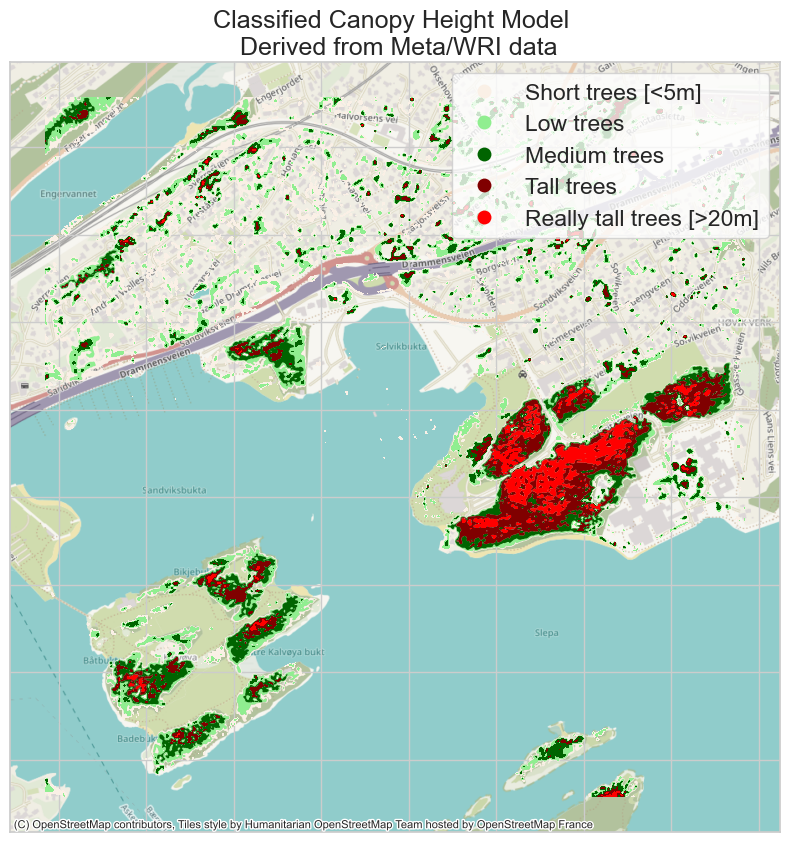

In [32]:
# Plot the result with the custom colormap and legend
fig, ax = plt.subplots(figsize=(10, 10))
gdf_dissolved_web_mercator.plot(column="class", 
                                cmap=cmap, 
                                legend=True, 
                                ax=ax, 
                                categorical=True, 
                                linewidth=0.0) #linewidth = 0 removes the borders.

# Add base map using contextily
ctx.add_basemap(ax, crs=gdf_dissolved_web_mercator.crs)

# Remove axes ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set(title="Classified Canopy Height Model \n Derived from Meta/WRI data")
plt.show()